<a href="https://colab.research.google.com/github/Jackuna/ai/blob/main/langgraph/langGraph_with_tools_ReAct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Langraph Chatbot with Tools as AI Agents using ReAct Architecture

In [ ]:
!pip install langchain_community langchainhub langgraph langchain langchain-groq langchain_tavily

In [3]:
from google.colab import userdata
import os

os.environ["SERPER_API_KEY"] = userdata.get('serper_key')
os.environ['GROQ_API_KEY'] = userdata.get('groq_api_key')


In [4]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import Tool

search = GoogleSerperAPIWrapper()

search_tool = Tool(
        name="Search_Tool",
        func=search.results,
        description="it is useful when you need to ask with search",
    )


#search_tool.run("Let me know a good substrate to grow dwarf hairgrass ?")



In [5]:
# Initiatalize LLM
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-8b-8192")

Custom Function using DocString

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
      a(int): The first integer.
      b(int): The second integer.
    Returns:
      The product of the two integers.
      int: output int
    """
    return a * b

def subtract(a: int, b: int) -> int:
    """subtract a by b.
    Args:
      a(int): The first integer.
      b(int): The second integer.
    Returns:
      The subtracted of the two integers.
      int: output int
    """
    return a - b

In [7]:
tools=[search_tool, multiply,subtract]

In [8]:
# Bind Tools with LLM
llm_with_tools = llm.bind_tools(tools)


In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    #state: str
    #message: str
    messages: Annotated[list[str], add_messages]

# ReAct Architecture
Act --> Observe --> Reason

In [10]:
# State Graph

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition

# Node Defination
def tool_calling_llm(state: State):
   return {"messages": [llm_with_tools.invoke(state['messages'])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

# Compile the Graph
graph = builder.compile()


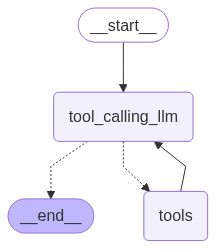

In [11]:
# Visualize the graph
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
response = graph.invoke({"messages": "multiply 63 by 1"})

response["messages"][-1].content

'63'

In [18]:
response = graph.invoke({"messages": "multiply 8 and 8"})

for val in response["messages"]:
  val.pretty_print()

================================ Human Message =================================

multiply 8 and 8
================================== Ai Message ==================================
Tool Calls:
  multiply (dm7znzpn9)
 Call ID: dm7znzpn9
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

64


In [19]:
response = graph.invoke({"messages": "subtract 9 by 91"})

for val in response["messages"]:
  val.pretty_print()

================================ Human Message =================================

subtract 9 by 91
================================== Ai Message ==================================
Tool Calls:
  subtract (ynz1w5fk5)
 Call ID: ynz1w5fk5
  Args:
    a: 91
    b: 9
================================= Tool Message =================================
Name: subtract

82
================================== Ai Message ==================================

<tool-use>{"tool_calls":[]}</tool-use>


In [21]:
response = graph.invoke({"messages": "who is the President of USA and then multiply 12 and 12"})

for val in response["messages"]:
  val.pretty_print()

================================ Human Message =================================

who is the President of USA and then multiply 12 and 12
================================== Ai Message ==================================
Tool Calls:
  Search_Tool (1gqbhr8vv)
 Call ID: 1gqbhr8vv
  Args:
    __arg1: who is the President of USA
================================= Tool Message =================================
Name: Search_Tool

{"searchParameters": {"q": "who is the President of USA", "gl": "us", "hl": "en", "type": "search", "num": 10, "engine": "google"}, "answerBox": {"title": "United States / President", "answer": "Donald Trump"}, "knowledgeGraph": {"title": "Donald Trump", "type": "45th and 47th U.S. President", "imageUrl": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSOpSNNTTnQQt9_M1jlNzxfjl66Y0WTu7qfQ8sPi5VCsvtohzYQWdiT7g&s=0", "description": "Donald John Trump is an American politician, media personality, and businessman who is the 47th president of the United States. A memb

In [22]:
response = graph.invoke({"messages": "search for latest Aquascape competitions"})

for val in response["messages"]:
  val.pretty_print()

================================ Human Message =================================

search for latest Aquascape competitions
================================== Ai Message ==================================
Tool Calls:
  Search_Tool (hed2m11s4)
 Call ID: hed2m11s4
  Args:
    __arg1: Aquascape competitions
================================= Tool Message =================================
Name: Search_Tool

{"searchParameters": {"q": "Aquascape competitions", "gl": "us", "hl": "en", "type": "search", "num": 10, "engine": "google"}, "organic": [{"title": "AGA Aquascaping Contest 2000-2023 Archive", "link": "https://showcase.aquatic-gardeners.org/", "snippet": "View the results of the AGA's 2000-2023 International Aquascaping Contest here. In addition, you can find 'vintage' live reveals from our livestreams.", "sitelinks": [{"title": "View Year", "link": "https://showcase.aquatic-gardeners.org/2023/"}, {"title": "2017", "link": "https://showcase.aquatic-gardeners.org/2017/"}, {"title": "2022"